### Objective
The goal of using GAN is to solve the problem of overfitting the CL classification due to possible duplicate images due to larger number of bootstrap iterations. Therefore, the current data generation process will involve both bootstrapp sampling followed by GAN. Half of the required dataset will be generated using bootstrap method and the rest will generated through GAN from this data


## Description
GAN refers to the " Generative Adversarial network". It is used to generate fake images as close as possible to the real images. GAN consists of two competing convolutional neural networks, Discriminator and Generator. Discrimator takes fake and real images as input and tries to disciminate them. Generator network generates fake images as close as possible to the real images to fool the discriminator. Therefore, by using the feedback from discriminator, generator updates its weights to produce more images as close as possible to the real images.

## Implementation
The following implementation shows a step by stemp implementation of GAN. This is a modified version of core from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/. The original was trained to generate fake images from MNIST dataset. I modified it to generate sample topomap images.

### 1. Define a standalone disciminator network
Discriminator (D) network takes images from real and fake datastets( from generator) and tries to discriminate them. Unlike normal CNN, D does not have softmax layer, instead it used sigmoid activation function to return the probability of images being real. Therefore,the output should be close to 1 for real images and zero for fake images.

In [20]:
import tensorflow as tf
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot as plt
import os
import cv2
import numpy as np
# define the standalone discriminator model
def define_discriminator(in_shape=(224,224,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


### 2.  Standalone generator model
The generator model is responsible for creating new fake but plausible topomap images. To do so, G takes point from latent space 

In [10]:

def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 14 * 14
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((14, 14,128)))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
  
  # upsample to 56x56
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    
     # upsample to 112x112
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
     # upsample to 224x224
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Conv2D(3, (7,7), activation='sigmoid', padding='same'))
    return model


In [11]:
gen=define_generator(100)
print(gen.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 25088)             2533888   
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 25088)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 56, 56, 128)       262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 56, 56, 128)      

### 3. define the combined generator and discriminator model, for updating the generator
Here we stack together our to models. The discriminato model is trained in standalone fashion since its main role to classfify two images. So in the composite models, its weight will be frozen to classify the input image from G. The weights of G will be updated based on the results from D

In [12]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model


### 4. Let's prepare our real and fake images

In [16]:
n_samples=15000
img_shape=(224,224)
path= "/home/kashraf/felix_hd/data_gen_may_2021/GAN_samples//"
filenames=os.listdir(path)
theta,beta,alpha,gamma,delta=[],[],[],[],[]

for filename in filenames:
    if "delta" in filename:
#         
        delta.append(filename)
    elif "theta" in filename:
        theta.append(filename)
    elif "alpha" in filename:
        alpha.append(filename)
    elif "beta" in filename:
        beta.append(filename)
    else:
        gamma.append(filename)
fnames=np.array(beta)
data=np.array([cv2.resize(cv2.imread(path+file)/255.0,img_shape) for file in fnames])
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input
 

In [17]:

 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_topos_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

In [ ]:
data.shape

### 5. Evaluate the Discriminator model

In [ ]:
# import tqdm
# for k in range(tqdm (10)):
#     print(k)

In [21]:
import tqdm

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=15000):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset,n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real topomap: %.0f%%, Accuracy fake topomaps: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename ='/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V4_allsamples.h5'
    g_model.save(filename)
 
   ##train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        print("-------------------CURRENT EPOCH-----------:",i+1)
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            print("------------EPOCH:{} BATCH :{}/{}--------------".format(i+1,j+1,bat_per_epo))
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('Discriminator Loss: {}\nGenerator Loss: {}\n'. format(d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % n_epochs == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
 


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# # load image data
dataset = data
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

-------------------CURRENT EPOCH-----------: 1
------------EPOCH:1 BATCH :1/234--------------
Discriminator Loss: 0.7208978533744812
Generator Loss: 0.19357116520404816

------------EPOCH:1 BATCH :2/234--------------
Discriminator Loss: 0.9019045233726501
Generator Loss: 0.4470287263393402

------------EPOCH:1 BATCH :3/234--------------
Discriminator Loss: 0.641363263130188
Generator Loss: 0.7689400315284729

------------EPOCH:1 BATCH :4/234--------------
Discriminator Loss: 0.6740750074386597
Generator Loss: 0.6266309022903442

------------EPOCH:1 BATCH :5/234--------------
Discriminator Loss: 0.6070281863212585
Generator Loss: 0.5005176663398743

------------EPOCH:1 BATCH :6/234--------------
Discriminator Loss: 0.5806394815444946
Generator Loss: 0.5570449829101562

------------EPOCH:1 BATCH :7/234--------------
Discriminator Loss: 0.5889787673950195
Generator Loss: 0.632716953754425

------------EPOCH:1 BATCH :8/234--------------
Discriminator Loss: 0.5584520101547241
Generator Loss

Discriminator Loss: 0.24024726450443268
Generator Loss: 1.3288047313690186

------------EPOCH:1 BATCH :68/234--------------
Discriminator Loss: 0.26927846670150757
Generator Loss: 1.2051751613616943

------------EPOCH:1 BATCH :69/234--------------
Discriminator Loss: 0.2506241798400879
Generator Loss: 1.3537731170654297

------------EPOCH:1 BATCH :70/234--------------
Discriminator Loss: 0.27352768182754517
Generator Loss: 1.3859124183654785

------------EPOCH:1 BATCH :71/234--------------
Discriminator Loss: 0.3381933867931366
Generator Loss: 1.08682382106781

------------EPOCH:1 BATCH :72/234--------------
Discriminator Loss: 0.3792485296726227
Generator Loss: 1.1990646123886108

------------EPOCH:1 BATCH :73/234--------------
Discriminator Loss: 0.3748272657394409
Generator Loss: 1.1855905055999756

------------EPOCH:1 BATCH :74/234--------------
Discriminator Loss: 0.3821718096733093
Generator Loss: 0.9332833886146545

------------EPOCH:1 BATCH :75/234--------------
Discriminator L

Discriminator Loss: 1.9831163883209229
Generator Loss: 1.6255860328674316

------------EPOCH:1 BATCH :135/234--------------
Discriminator Loss: 0.18460476398468018
Generator Loss: 0.5970615148544312

------------EPOCH:1 BATCH :136/234--------------
Discriminator Loss: 0.4548567533493042
Generator Loss: 2.3525164127349854

------------EPOCH:1 BATCH :137/234--------------
Discriminator Loss: 0.16499659419059753
Generator Loss: 3.114006519317627

------------EPOCH:1 BATCH :138/234--------------
Discriminator Loss: 0.21418145298957825
Generator Loss: 1.9035005569458008

------------EPOCH:1 BATCH :139/234--------------
Discriminator Loss: 0.16341041028499603
Generator Loss: 1.5685999393463135

------------EPOCH:1 BATCH :140/234--------------
Discriminator Loss: 0.22194933891296387
Generator Loss: 2.0470240116119385

------------EPOCH:1 BATCH :141/234--------------
Discriminator Loss: 0.16142921149730682
Generator Loss: 2.416126251220703

------------EPOCH:1 BATCH :142/234--------------
Disc

Discriminator Loss: 0.14563217759132385
Generator Loss: 1.6091235876083374

------------EPOCH:1 BATCH :201/234--------------
Discriminator Loss: 0.13881152868270874
Generator Loss: 3.3570005893707275

------------EPOCH:1 BATCH :202/234--------------
Discriminator Loss: 0.1274675726890564
Generator Loss: 2.045225143432617

------------EPOCH:1 BATCH :203/234--------------
Discriminator Loss: 0.12834684550762177
Generator Loss: 3.3193650245666504

------------EPOCH:1 BATCH :204/234--------------
Discriminator Loss: 0.11938594281673431
Generator Loss: 2.008291721343994

------------EPOCH:1 BATCH :205/234--------------
Discriminator Loss: 0.11763456463813782
Generator Loss: 3.14951753616333

------------EPOCH:1 BATCH :206/234--------------
Discriminator Loss: 0.11231648921966553
Generator Loss: 2.099900960922241

------------EPOCH:1 BATCH :207/234--------------
Discriminator Loss: 0.10500539839267731
Generator Loss: 2.732309579849243

------------EPOCH:1 BATCH :208/234--------------
Discrim

Discriminator Loss: 0.08619861304759979
Generator Loss: 2.7349228858947754

------------EPOCH:2 BATCH :33/234--------------
Discriminator Loss: 0.07848943769931793
Generator Loss: 2.842048168182373

------------EPOCH:2 BATCH :34/234--------------
Discriminator Loss: 0.08680104464292526
Generator Loss: 2.446859359741211

------------EPOCH:2 BATCH :35/234--------------
Discriminator Loss: 0.08040618151426315
Generator Loss: 2.7511391639709473

------------EPOCH:2 BATCH :36/234--------------
Discriminator Loss: 0.07856905460357666
Generator Loss: 3.2813613414764404

------------EPOCH:2 BATCH :37/234--------------
Discriminator Loss: 0.0781460553407669
Generator Loss: 2.211153030395508

------------EPOCH:2 BATCH :38/234--------------
Discriminator Loss: 0.0846763402223587
Generator Loss: 3.264108657836914

------------EPOCH:2 BATCH :39/234--------------
Discriminator Loss: 0.06367869675159454
Generator Loss: 3.301342487335205

------------EPOCH:2 BATCH :40/234--------------
Discriminator L

Discriminator Loss: 0.06317984312772751
Generator Loss: 3.0809073448181152

------------EPOCH:2 BATCH :100/234--------------
Discriminator Loss: 0.06248318403959274
Generator Loss: 3.062034845352173

------------EPOCH:2 BATCH :101/234--------------
Discriminator Loss: 0.04813355579972267
Generator Loss: 3.0425291061401367

------------EPOCH:2 BATCH :102/234--------------
Discriminator Loss: 0.05433807149529457
Generator Loss: 2.9324159622192383

------------EPOCH:2 BATCH :103/234--------------
Discriminator Loss: 0.0706191286444664
Generator Loss: 3.040513515472412

------------EPOCH:2 BATCH :104/234--------------
Discriminator Loss: 0.06748567521572113
Generator Loss: 2.974451780319214

------------EPOCH:2 BATCH :105/234--------------
Discriminator Loss: 0.0655854269862175
Generator Loss: 2.797178268432617

------------EPOCH:2 BATCH :106/234--------------
Discriminator Loss: 0.07120935618877411
Generator Loss: 2.764810800552368

------------EPOCH:2 BATCH :107/234--------------
Discrim

Discriminator Loss: 2.0258426666259766
Generator Loss: 0.007815354503691196

------------EPOCH:2 BATCH :166/234--------------
Discriminator Loss: 2.2637767791748047
Generator Loss: 1.4582757949829102

------------EPOCH:2 BATCH :167/234--------------
Discriminator Loss: 0.24642492830753326
Generator Loss: 6.034636974334717

------------EPOCH:2 BATCH :168/234--------------
Discriminator Loss: 0.489128977060318
Generator Loss: 2.9615087509155273

------------EPOCH:2 BATCH :169/234--------------
Discriminator Loss: 0.10637900233268738
Generator Loss: 1.5207769870758057

------------EPOCH:2 BATCH :170/234--------------
Discriminator Loss: 0.16599078476428986
Generator Loss: 2.144361972808838

------------EPOCH:2 BATCH :171/234--------------
Discriminator Loss: 0.11614543199539185
Generator Loss: 3.037597179412842

------------EPOCH:2 BATCH :172/234--------------
Discriminator Loss: 0.10849009454250336
Generator Loss: 3.0368595123291016

------------EPOCH:2 BATCH :173/234--------------
Discr

Discriminator Loss: 0.10008350014686584
Generator Loss: 2.5605995655059814

------------EPOCH:2 BATCH :232/234--------------
Discriminator Loss: 0.1093318909406662
Generator Loss: 2.9752819538116455

------------EPOCH:2 BATCH :233/234--------------
Discriminator Loss: 0.10393308848142624
Generator Loss: 2.2792623043060303

------------EPOCH:2 BATCH :234/234--------------
Discriminator Loss: 0.1139817088842392
Generator Loss: 2.3501617908477783

-------------------CURRENT EPOCH-----------: 3
------------EPOCH:3 BATCH :1/234--------------
Discriminator Loss: 0.1258493810892105
Generator Loss: 2.7503461837768555

------------EPOCH:3 BATCH :2/234--------------
Discriminator Loss: 0.13632230460643768
Generator Loss: 2.2500765323638916

------------EPOCH:3 BATCH :3/234--------------
Discriminator Loss: 0.11963304132223129
Generator Loss: 2.3398258686065674

------------EPOCH:3 BATCH :4/234--------------
Discriminator Loss: 0.11372150480747223
Generator Loss: 2.8630337715148926

------------E

Discriminator Loss: 0.06808550655841827
Generator Loss: 3.6103408336639404

------------EPOCH:3 BATCH :64/234--------------
Discriminator Loss: 0.08267845213413239
Generator Loss: 2.4124765396118164

------------EPOCH:3 BATCH :65/234--------------
Discriminator Loss: 0.06607029587030411
Generator Loss: 2.9781124591827393

------------EPOCH:3 BATCH :66/234--------------
Discriminator Loss: 0.060731079429388046
Generator Loss: 3.341587543487549

------------EPOCH:3 BATCH :67/234--------------
Discriminator Loss: 0.0664864331483841
Generator Loss: 2.6420130729675293

------------EPOCH:3 BATCH :68/234--------------
Discriminator Loss: 0.059646863490343094
Generator Loss: 3.2113945484161377

------------EPOCH:3 BATCH :69/234--------------
Discriminator Loss: 0.052954256534576416
Generator Loss: 3.0904603004455566

------------EPOCH:3 BATCH :70/234--------------
Discriminator Loss: 0.042682938277721405
Generator Loss: 3.1777148246765137

------------EPOCH:3 BATCH :71/234--------------
Discri

Discriminator Loss: 0.04662160947918892
Generator Loss: 3.605243444442749

------------EPOCH:3 BATCH :131/234--------------
Discriminator Loss: 0.05489540845155716
Generator Loss: 2.6574482917785645

------------EPOCH:3 BATCH :132/234--------------
Discriminator Loss: 0.06794998794794083
Generator Loss: 3.8547019958496094

------------EPOCH:3 BATCH :133/234--------------
Discriminator Loss: 0.06337851285934448
Generator Loss: 2.949629306793213

------------EPOCH:3 BATCH :134/234--------------
Discriminator Loss: 0.055277593433856964
Generator Loss: 3.153184652328491

------------EPOCH:3 BATCH :135/234--------------
Discriminator Loss: 0.051260191947221756
Generator Loss: 3.3442163467407227

------------EPOCH:3 BATCH :136/234--------------
Discriminator Loss: 0.05054706335067749
Generator Loss: 2.8744921684265137

------------EPOCH:3 BATCH :137/234--------------
Discriminator Loss: 0.03640531003475189
Generator Loss: 3.4808638095855713

------------EPOCH:3 BATCH :138/234--------------
D

Discriminator Loss: 0.03838425874710083
Generator Loss: 2.936464786529541

------------EPOCH:3 BATCH :197/234--------------
Discriminator Loss: 0.04850149154663086
Generator Loss: 3.5537524223327637

------------EPOCH:3 BATCH :198/234--------------
Discriminator Loss: 0.03971501439809799
Generator Loss: 3.496678590774536

------------EPOCH:3 BATCH :199/234--------------
Discriminator Loss: 0.03854041174054146
Generator Loss: 3.3223557472229004

------------EPOCH:3 BATCH :200/234--------------
Discriminator Loss: 0.04329364001750946
Generator Loss: 3.330658197402954

------------EPOCH:3 BATCH :201/234--------------
Discriminator Loss: 0.04030966758728027
Generator Loss: 3.5669405460357666

------------EPOCH:3 BATCH :202/234--------------
Discriminator Loss: 0.04473176971077919
Generator Loss: 3.597843647003174

------------EPOCH:3 BATCH :203/234--------------
Discriminator Loss: 0.04174547642469406
Generator Loss: 3.046208620071411

------------EPOCH:3 BATCH :204/234--------------
Discr

Discriminator Loss: 0.03018048033118248
Generator Loss: 3.4881792068481445

------------EPOCH:4 BATCH :29/234--------------
Discriminator Loss: 0.025325629860162735
Generator Loss: 3.6828529834747314

------------EPOCH:4 BATCH :30/234--------------
Discriminator Loss: 0.022650180384516716
Generator Loss: 3.6806201934814453

------------EPOCH:4 BATCH :31/234--------------
Discriminator Loss: 0.027008697390556335
Generator Loss: 3.9162139892578125

------------EPOCH:4 BATCH :32/234--------------
Discriminator Loss: 0.0374438650906086
Generator Loss: 4.39117431640625

------------EPOCH:4 BATCH :33/234--------------
Discriminator Loss: 0.04348192363977432
Generator Loss: 3.3384923934936523

------------EPOCH:4 BATCH :34/234--------------
Discriminator Loss: 0.03350961208343506
Generator Loss: 3.499498128890991

------------EPOCH:4 BATCH :35/234--------------
Discriminator Loss: 0.030739430338144302
Generator Loss: 3.7740159034729004

------------EPOCH:4 BATCH :36/234--------------
Discrimi

Discriminator Loss: 0.027168285101652145
Generator Loss: 4.039505958557129

------------EPOCH:4 BATCH :96/234--------------
Discriminator Loss: 0.029083719477057457
Generator Loss: 3.5970871448516846

------------EPOCH:4 BATCH :97/234--------------
Discriminator Loss: 0.027326196432113647
Generator Loss: 3.794710636138916

------------EPOCH:4 BATCH :98/234--------------
Discriminator Loss: 0.020585665479302406
Generator Loss: 4.1984381675720215

------------EPOCH:4 BATCH :99/234--------------
Discriminator Loss: 0.022593475878238678
Generator Loss: 3.870481014251709

------------EPOCH:4 BATCH :100/234--------------
Discriminator Loss: 0.02013459987938404
Generator Loss: 4.18938684463501

------------EPOCH:4 BATCH :101/234--------------
Discriminator Loss: 0.025762321427464485
Generator Loss: 4.268466949462891

------------EPOCH:4 BATCH :102/234--------------
Discriminator Loss: 0.024097822606563568
Generator Loss: 4.207879066467285

------------EPOCH:4 BATCH :103/234--------------
Disc

### Final: Using generator model to generate images

In [ ]:
# example of loading the generator model and generating images
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt
from keras.models import load_model
import h5py


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data\
#         plt.savefig()
        plt.imshow(examples[i, :, :, 0])
    plt.show()
import tensorflow as tf
# load model
model = tf.keras.models.load_model('/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V2.h5')
# generate images
latent_points = generate_latent_points(100,10)
# generate images


# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#         model = load_model('/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V2.h5')


In [ ]:
# path="/home/kashraf/Research_2021/GAN_topomap/generated_images/Un_GAN_generator_V2//"
# # model=tf.keras.models.load_model('/home/kashraf/Research_2021/GAN_topomap/saved_models/Un_GAN_generator_V2.h5')
# latent_points= generate_latent_points(100,200)
# X =g_model.predict(latent_points)
# generated_img=[((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8') for arr in X]
# generated_img = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in generated_img]
# for i in range(len(generated_img)):
#     plt.imsave(path+"beta_"+str(i)+".png",generated_img[i])

# # # plot the result
# # plt.figure(figsize=(10,10))
# # plt.imshow(generated_img[2])
# # plt.show()

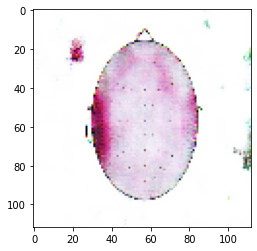

In [60]:
plt.imshow(generated_img[0])